# Load data

In [21]:
%pylab inline
plt.style.use("default")
import os, sys
import scipy
import helpers as h
from glob import glob
from scipy.io import loadmat
from scipy.sparse.linalg import eigsh
from mpl_toolkits import mplot3d
from scipy.stats import skewnorm 
from scipy.stats import skew, kurtosis
import matplotlib.gridspec as Gridspec

plt.rcParams['figure.figsize'] = (15, 5) 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Purpose

In this notebook, we want to browse some of the datasets that we have loaded in a simple way.

In [22]:
def pad_vector(v, desired_length, pad_with = np.nan):
    v_new = np.zeros((desired_length,))
    v_new[:len(v)] = v
    v_new[len(v):] = pad_with
    return v_new

In [23]:
def abib_cdf(r, r_min = -np.inf, **kwargs):
    r_kept = r[r>r_min]
    print(f"Dropped {len(r) - len(r_kept)} values less than {r_min=}")
    x = sorted(r_kept)
    y = arange(1, len(r_kept)+1)/(len(r_kept))
    plot(x,y, **kwargs)
    xlabel("Samples"); ylabel("Cumulative Probability")
    return r_kept

In [24]:
data_root = "/Users/duuta/ppp/data/stringer/"

In [25]:
data_files = [fname.split("/")[-1] for fname in glob(f"{data_root}natimg2800_M*.mat")]
data_files

['natimg2800_M170717_MP034_2017-09-11.mat',
 'natimg2800_M170714_MP032_2017-08-07.mat',
 'natimg2800_M170717_MP033_2017-08-20.mat',
 'natimg2800_M160825_MP027_2016-12-14.mat',
 'natimg2800_M161025_MP030_2017-05-29.mat',
 'natimg2800_M170714_MP032_2017-09-14.mat',
 'natimg2800_M170604_MP031_2017-06-28.mat']

In [26]:
data = loadmat(os.path.join(data_root, data_files[1])
               ,simplify_cells = True) 

In [27]:
def load_stringer_data():
    pass

In [28]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'db', 'med', 'stat', 'stim'])

# Plot ROIs using data.med

In [29]:
data['stim']['resp'].shape

(5880, 9039)

In [30]:
len(unique(data['stim']['spont'])) # 11371087 what does this number represent 

11371087

In [31]:
spont = data['stim']['spont']
resp = data['stim']['resp']

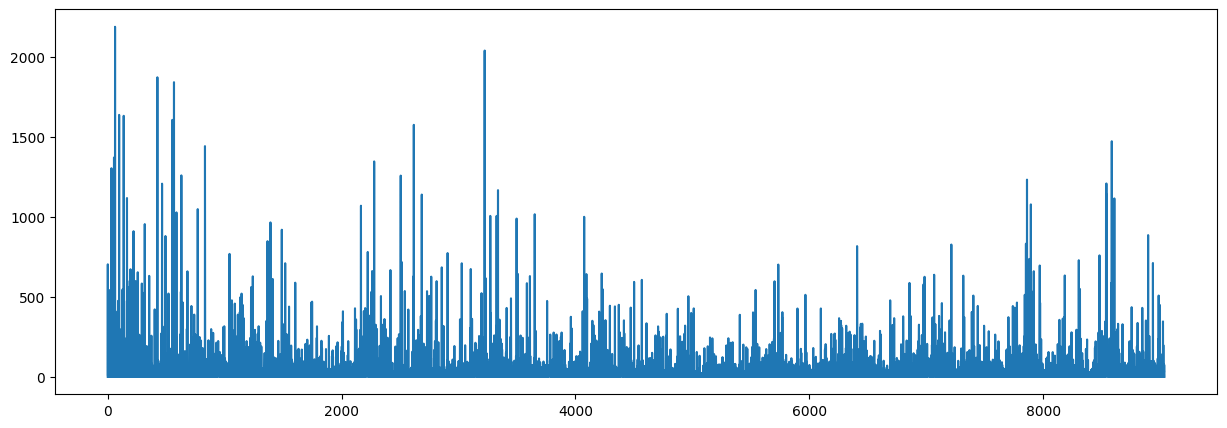

In [32]:
plot(spont[1, :]);

# add CDF to plots

Dropped 0 values less than r_min=-inf
Dropped 0 values less than r_min=-inf


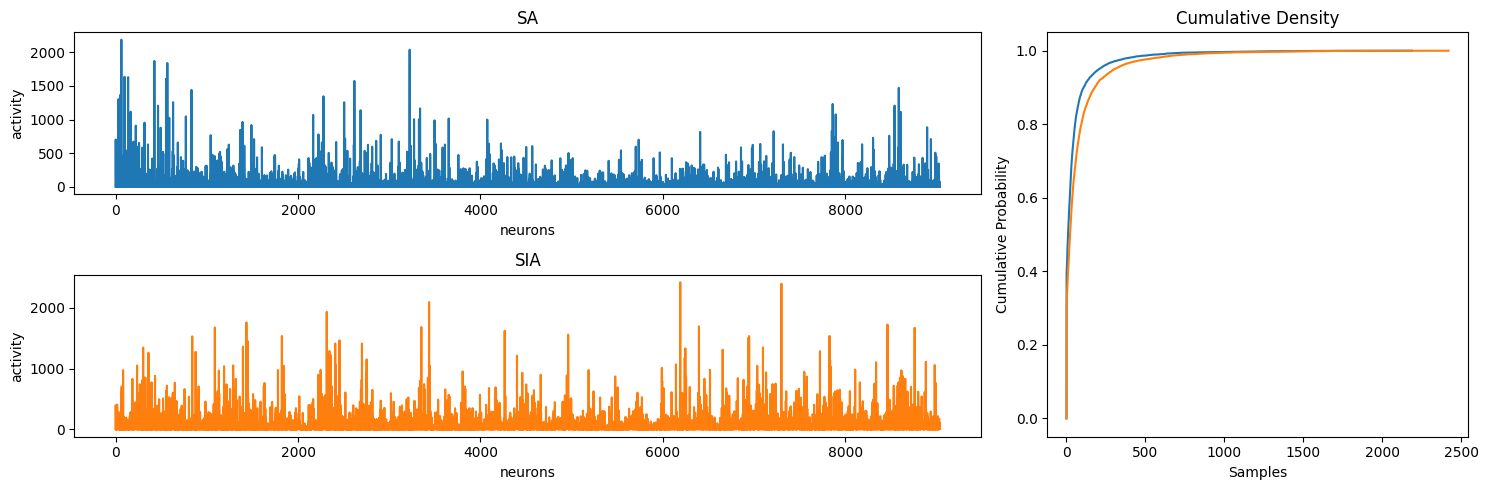

In [33]:
# compare spontaneous activity (SA) to stimulus induced activity (RIA) of neurons
fg = plt.figure(constrained_layout=True)
gs = GridSpec(2,3)

ax_spont= fg.add_subplot(gs[0, :-1])
plot(spont[1, :])
title('SA')
xlabel('neurons')
ylabel('activity')
ax_resp= fg.add_subplot(gs[1, :-1])
plot(resp[1, :], color="C1") 
title('SIA') 
xlabel('neurons') 
ylabel('activity') 
ax_cdf = fg.add_subplot(gs[:, -1])
abib_cdf(spont[1, :])
abib_cdf(resp[1, :])
title("Cumulative Density")

tight_layout()

Dropped 0 values less than r_min=-inf
Dropped 0 values less than r_min=-inf


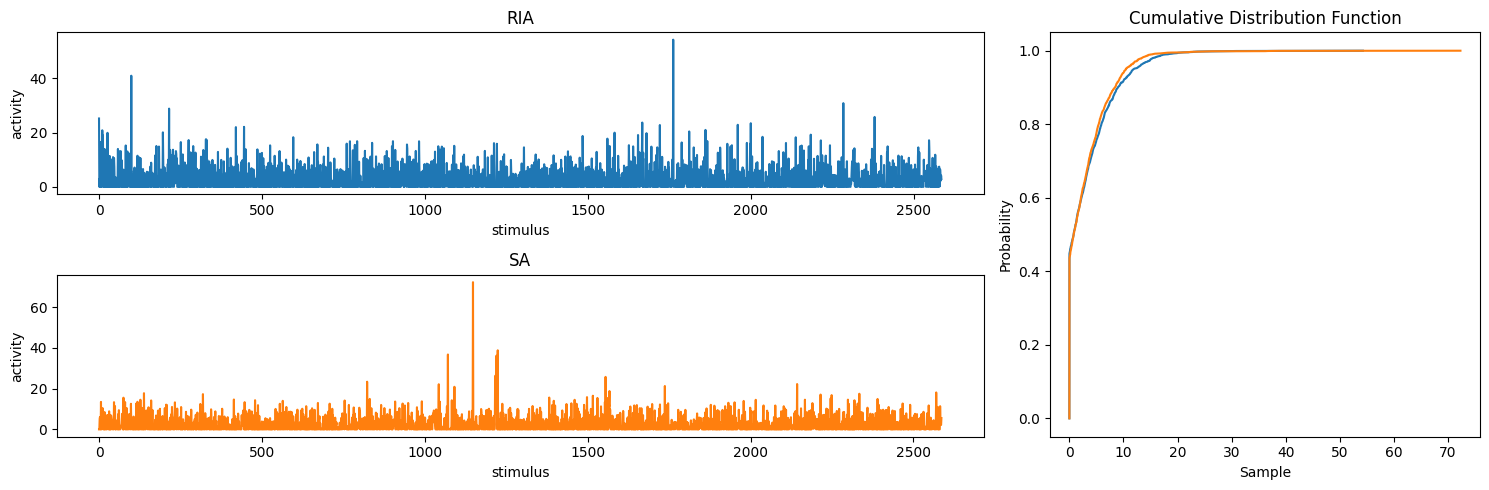

In [34]:
# compare spontaneous activity (SA) to response induced activity (RIA) of the neuron
fig0 = plt.figure(constrained_layout= True)
gs0= GridSpec(2, 2)

ax0_spont = fig0.add_subplot(gs[0, :-1])
plot(spont[:, 0])
title('RIA')
xlabel('stimulus')
ylabel('activity')

ax0_resp = fig0.add_subplot(gs[1, :-1] )
plot(resp[:2587, 0], color='C1') 
title('SA') 
xlabel('stimulus') 
ylabel('activity') 

ax0_cdf = fig0.add_subplot(gs[:, -1])
abib_cdf(spont[:, 0])
abib_cdf(resp[:2587, 0])
title('Cumulative Distribution Function')
xlabel("Sample")
ylabel('Probability')
tight_layout() #skewed

# abib's metric
# E[X]^2_2 = n

In [35]:
def abib_metric(X):
    n = X.shape[0]
    X2 = X**2
    EX2 = mean(sum(X2, axis=0))
    r = EX2/n
    return r 

Text(0, 0.5, 'Value')

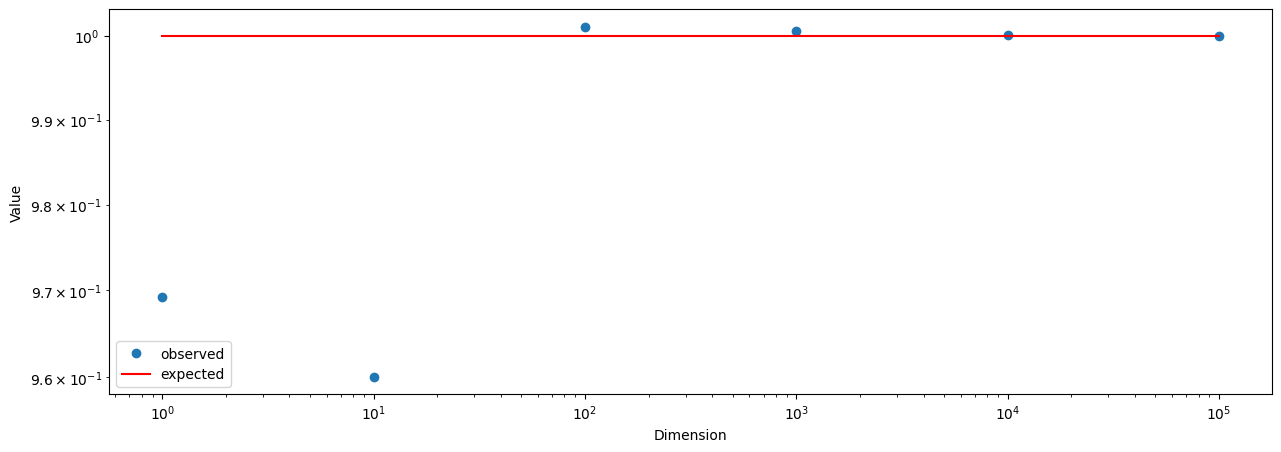

In [36]:
# TEST
n_dims = [10**j for j in np.arange(0, 6)]
n_pts = 1000
ns = []
for j  in n_dims:
    sap = randn(j, n_pts)
    r = abib_metric(sap)
    ns.append(r)
loglog(n_dims, ns, 'o', label='observed')
loglog(n_dims, [1]*len(n_dims), 'r', label='expected')
legend();
xlabel('Dimension')
ylabel('Value')

In [37]:
abib_metric(sap)

0.9999626267192376

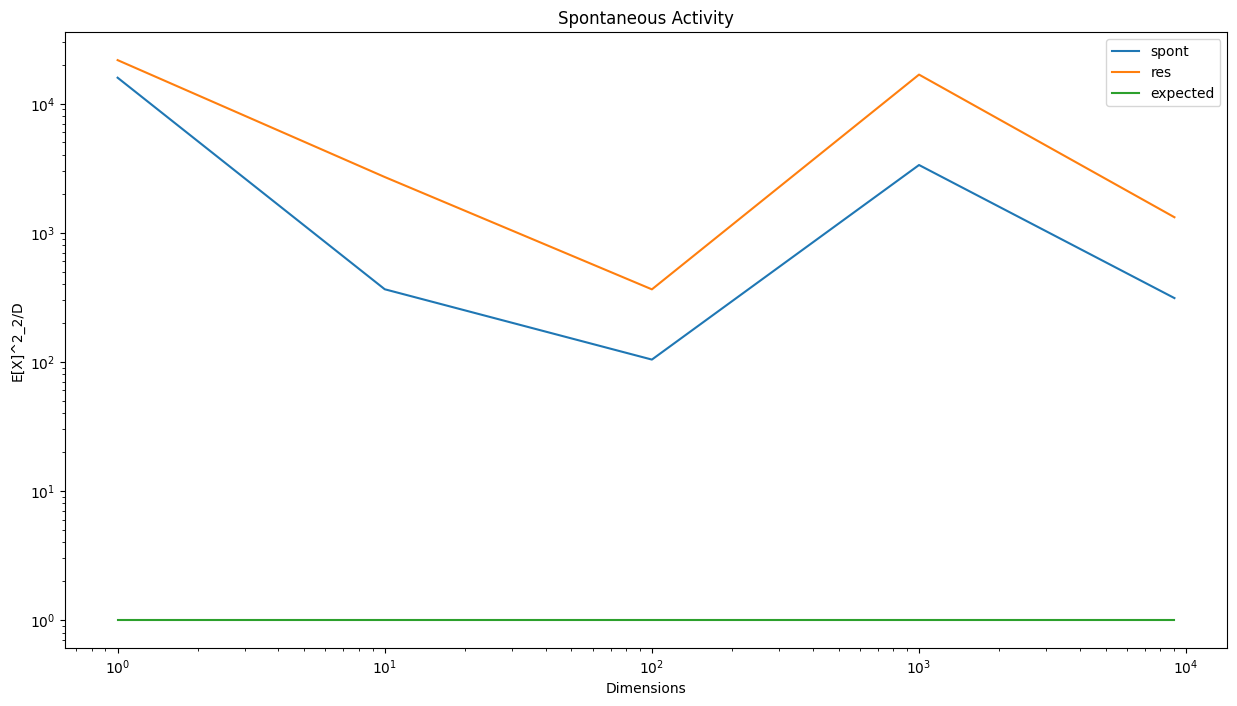

In [38]:
# REAL data
ns_dims = n_dims[:4] + [9038]
spont_results =[]
resResults = []
for _n in ns_dims:
    dx, dr  = spont[:, _n], resp[:, _n]
    rx, rr = abib_metric(dx), abib_metric(dr)
    spont_results.append(rx)
    resResults.append(rr)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
ax.loglog(ns_dims, spont_results, label= 'spont')
ax.loglog(ns_dims, resResults, label='res')
ax.loglog(ns_dims, [1]*len(ns_dims), label = 'expected')
ax.set_xlabel('Dimensions')
ax.set_ylabel('E[X]^2_2/D')
ax.set_title('Spontaneous Activity')

legend();

In [39]:
# correlation of the spontaneouness activity with the 
cc = np.empty(spont.shape[0],)
for i in range(spont.shape[0]):
    cc[i,] = np.corrcoef(resp[i, :], spont[2, :])[0,1]

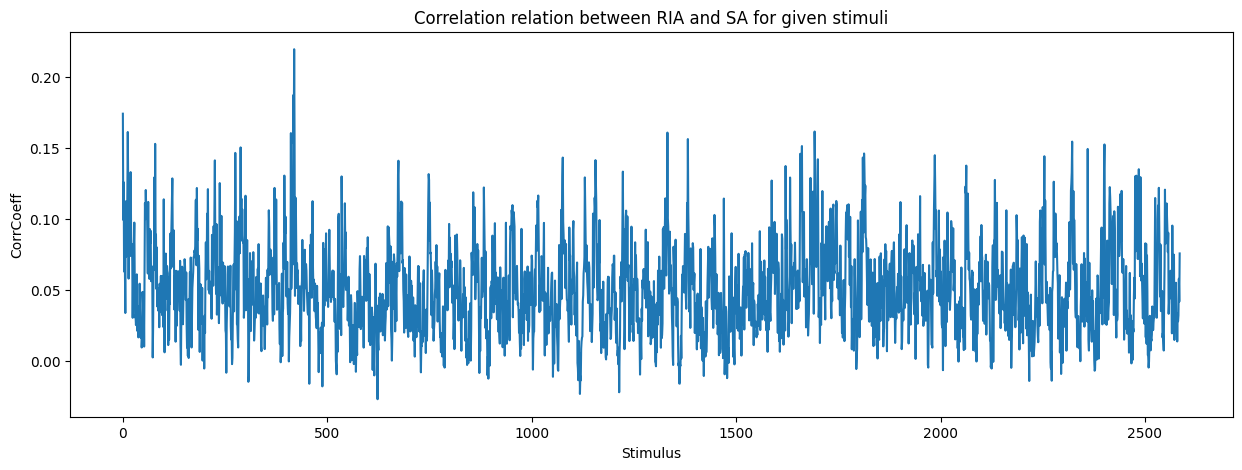

In [40]:
plot(cc);
xlabel('Stimulus')
ylabel('CorrCoeff')
title("Correlation relation between RIA and SA for given stimuli");

In [41]:
sum(spont, axis=0).shape

(9039,)

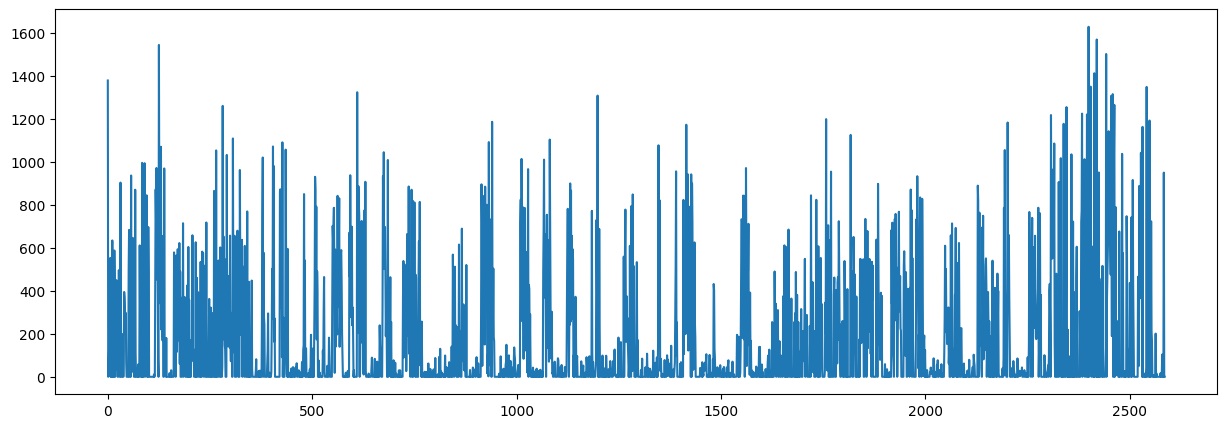

In [42]:
maxidx=np.argmax(sum(spont, axis=0)) # neuron with max SA
maxSA = spont[:, maxidx]
plot(maxSA);

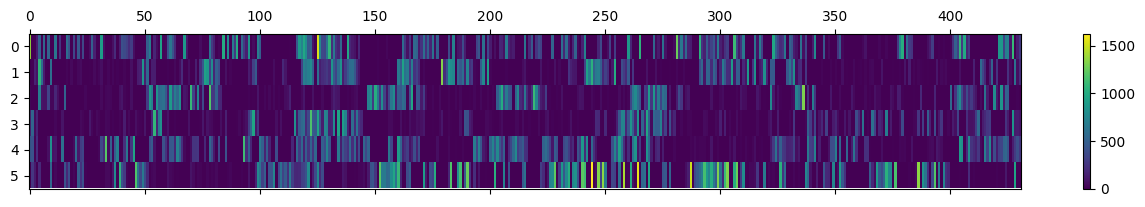

In [43]:
matshow(spont[:,  maxidx].reshape(6, 431))# max SA of the 
axis("auto")
colorbar();

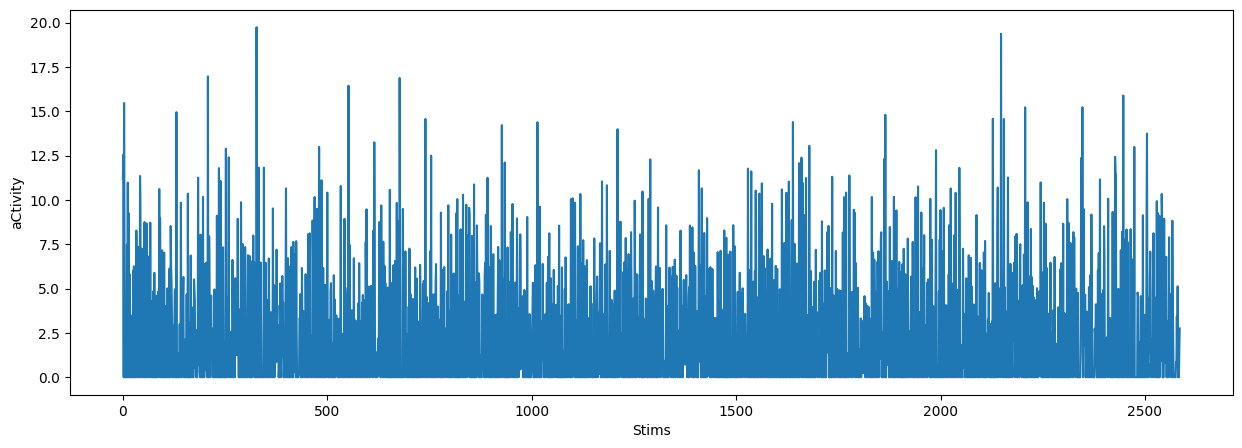

In [44]:
minidx= np.argmin(sum(spont, axis=0))
minSA = spont[:, minidx]
plot(minSA);
xlabel('Stims')
ylabel("aCtivity");

In [45]:
ss = h.test_vars(spont)

In [46]:
alpha, afit = h.get_alpha_fit(ss, np.arange(10, 5e2).astype('int'))

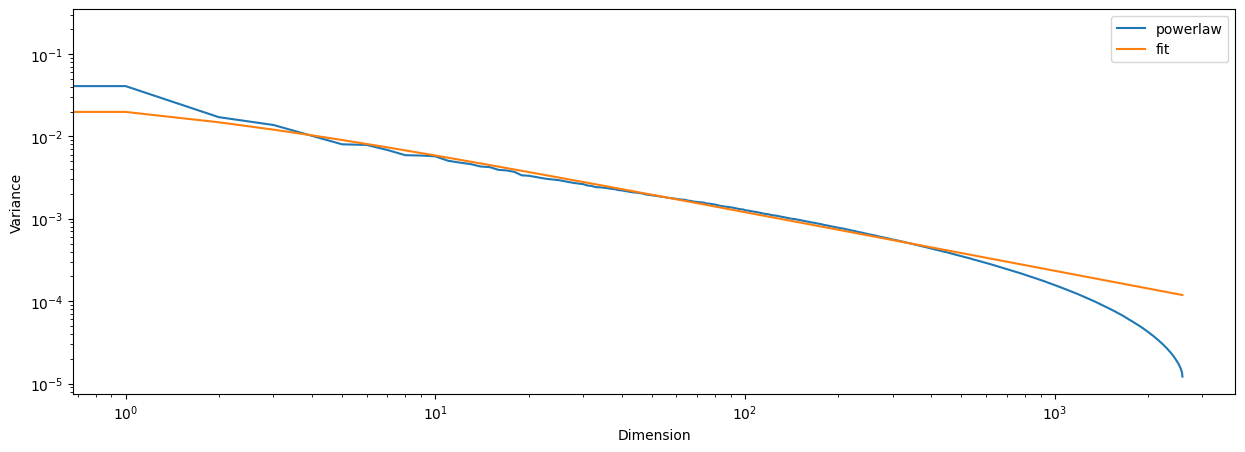

In [47]:
loglog(ss, label='powerlaw')
ylabel("Variance")
xlabel("Dimension")
plot(afit, label='fit')
legend();

In [48]:
Xspont = spont[spont>0]

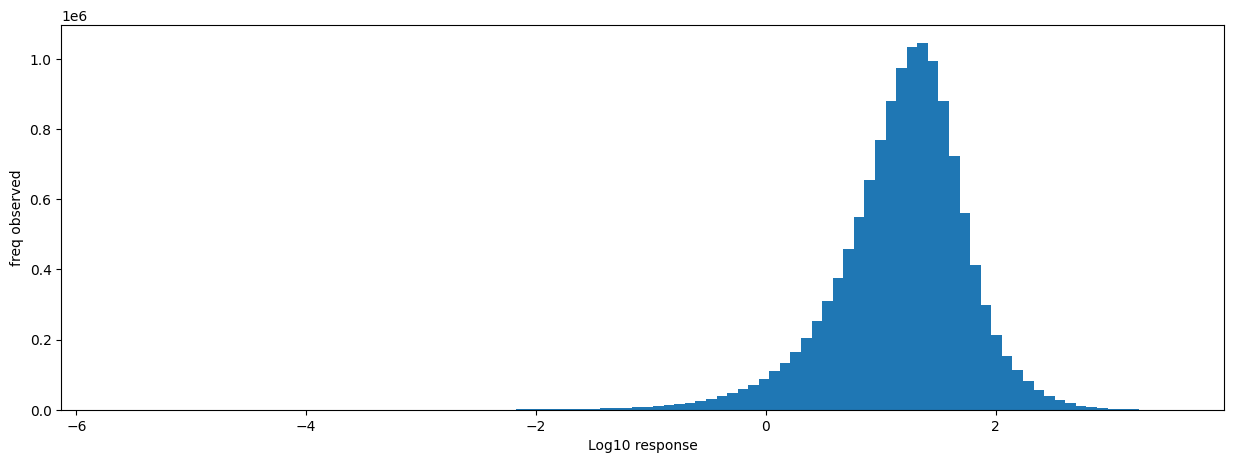

In [49]:
hist(log10(Xspont,), bins=100);
xlabel('Log10 response')
ylabel('freq observed');

In [50]:
N = 2
b = np.random.randn(N, N)
b_symm = 0.5*(b + b.T) + N*eye(N)

In [51]:
N*eye(N)

array([[2., 0.],
       [0., 2.]])

In [35]:
au, av = scipy.sparse.linalg.eigsh(b_symm)

/Users/duuta/ppp/venv/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


In [36]:
t = linspace(0, 2*pi)

In [37]:
tt =np.array([cos(t), sin(t)])

In [38]:
(tt * au.reshape(2,1)).shape

(2, 50)

In [85]:
def rend_cov(x):
    xe, xv = eigsh(x)
    xe_ = np.sqrt(xe)
    xe_ = xe_[:2, ]
    t = linspace(0, 2*pi, 100)
    t_ = np.array([cos(t), sin(t)])
    es = xv @ (xe_.reshape(2, 1) * t_) 
    plot(es[0], es[1], )
    

    return None

[1.23753775 3.67896632]
[[-0.90366469 -0.42824074]
 [-0.42824074  0.90366469]]
[0.57702462 2.82847546]
[[-0.87850299 -0.47773686]
 [-0.47773686  0.87850299]]


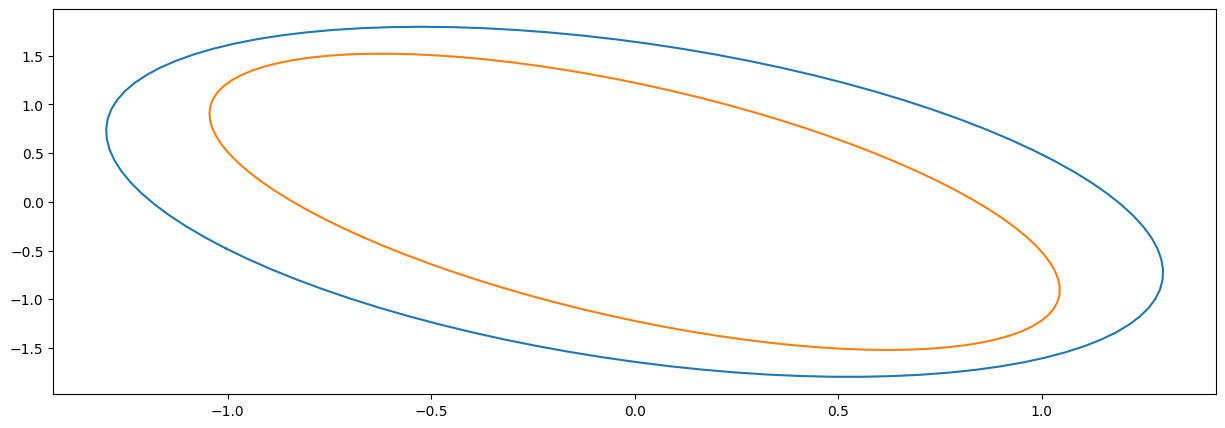

In [40]:
bx = randn(2, 2)
covx = 0.5*(bx + bx.T) + 2*eye(2)
rend_cov(covx)
cvx = bx @ bx.T
rend_cov(cvx)

[1.23753775 3.67896632]
[[-0.90366469 -0.42824074]
 [-0.42824074  0.90366469]]


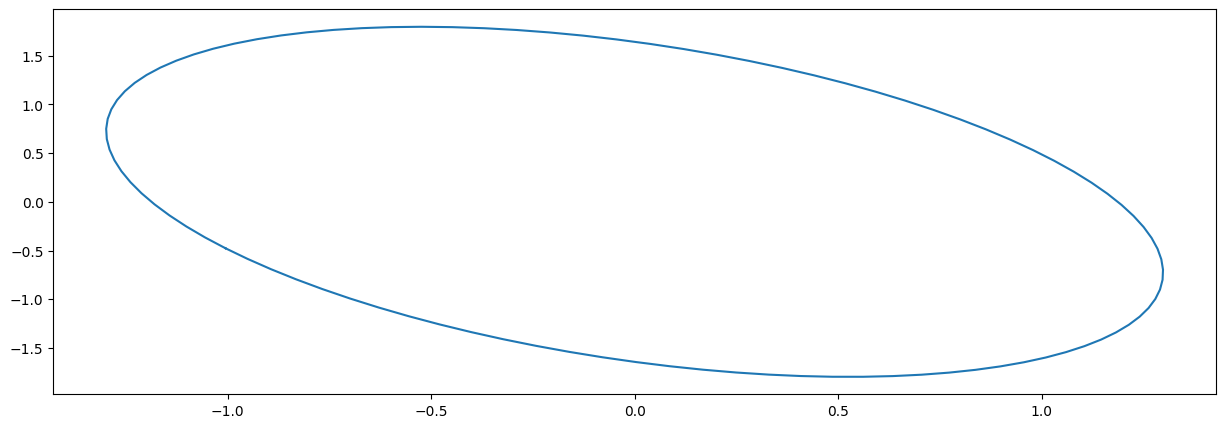

In [42]:
rend_cov(covx)

# how exactly we read out the properties of probability ellipse from the covariance matrix
what's special about covariant matrices: positive definite, symmetric

is it possible for covariant matrices to represent hyperbola: no

what property of the covariant matrix to allow a representation of a hyperbola: determinant(=0)

function input as covariant matrix, output plot ellipses of the matrix and principal directions with the exact lengths and gaussian data on top.

# cross correlations of spont vs response

In [90]:
xsr = corrcoef(spont, resp)


In [85]:
spont.shape

(2586, 9039)

In [86]:
resp.shape

(5880, 9039)

In [87]:
spont.shape[0] + resp.shape[0]

8466

In [91]:
xsr.shape

(8466, 8466)

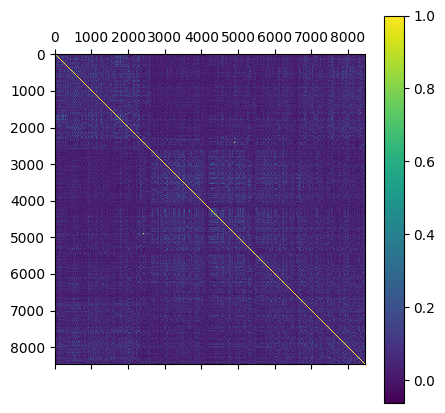

In [29]:
matshow(xsr)
colorbar();
# add labels

# subgaussian & exponential norm

In [43]:
return_vec = []
xs = randn(1000,)  # test data: generate some X's
t = linspace(0.01, 1000, 100)  # gen some t's

def subG(xs, t=linspace(0.01, 1000, 100000)):
    sxs = xs**2
    for j in t:
        d = exp(sxs/j**2)
        if mean(d) <= 2:
            print(mean(d))
            return j        
    return np.inf


def subE(xs, t = linspace(0.01, 1000, 100000)):
    for j in t:
        d = exp(abs(xs)/j)
        if mean(d) <= 2:
            print(mean(d))
            return j
    return np.inf

# collapse these into function
### don't have expectations

In [44]:
subG(xs)

1.9683646922246163


/var/folders/f4/q6n418p95nb77wmf4l9zydddrkwtmh/T/ipykernel_13409/2700130120.py:8: RuntimeWarning: overflow encountered in exp
  d = exp(sxs/j**2)
/Users/duuta/ppp/venv/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


1.6300000000000001

In [45]:
spont_ = spont**2
for j in t:
        d = exp(spont_/j**2)
        d_ = d[d<np.inf]
        Ed = mean(d_)
        if Ed <= 2:  # implement diff (track two vars)
            return_vec.append(j)

/var/folders/f4/q6n418p95nb77wmf4l9zydddrkwtmh/T/ipykernel_13409/1461943199.py:3: RuntimeWarning: overflow encountered in exp
  d = exp(spont_/j**2)


In [46]:
mean(d_)

1.0149516

In [48]:
es = av @  au.reshape(2,1) * tt 

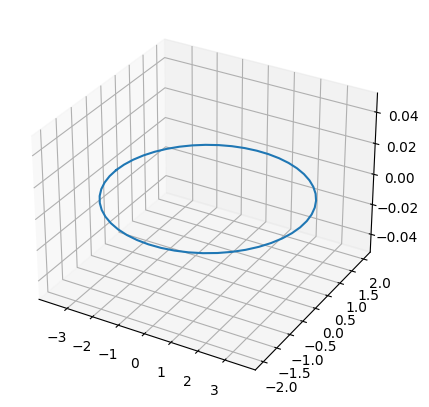

In [49]:
ax = axes(projection='3d')
ax.plot(es[0], es[1]);

In [50]:
au.reshape(2,1) * au.reshape(2,1).T

array([[ 2.61926377,  6.11467416],
       [ 6.11467416, 14.27471356]])

In [51]:
outer(au, au)

array([[ 2.61926377,  6.11467416],
       [ 6.11467416, 14.27471356]])

In [127]:
## fig = figure()
# ax = axes(projection='3d')
# # x, y, z = data['stim']["spont"].T
# ax.scatter(x,y,z, s=1)
# ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

# data.stat

In [53]:
data["stat"][0].keys()

dict_keys(['ipix', 'ypix', 'xpix', 'lam', 'lambda', 'npix', 'med', 'neuropilCoefficient', 'baseline', 'footprint', 'mrs', 'mrs0', 'cmpct', 'aspect_ratio', 'ellipse', 'mimgProj', 'mimgProjAbs', 'isoverlap', 'radius', 'ipix_neuropil', 'dFstat', 'skew', 'std', 'maxMinusMed', 'top5pcMinusMed', 'blockstarts', 'iplane', 'iscell', 'noiseLevel', 'redcell', 'redprob', 'notred'])

We can probably ignore this for now.

# data.stim

In [54]:
data["stim"].keys()

dict_keys(['spont', 'resp', 'istim'])

In [55]:
data["stim"]["spont"].shape

(2586, 9039)

In [56]:
data["stim"]["resp"].shape

(5880, 9039)

In [57]:
data["stim"]["istim"].shape

(5880,)

In [58]:
print(f"Number of unique stimuli presented: {len(unique(data['stim']['istim']))}")

Number of unique stimuli presented: 2801


# Let's look at some responses

In [59]:
X = data["stim"]["resp"]
X.shape

(5880, 9039)

Text(0.5, 1.0, 'ROI responses to images')

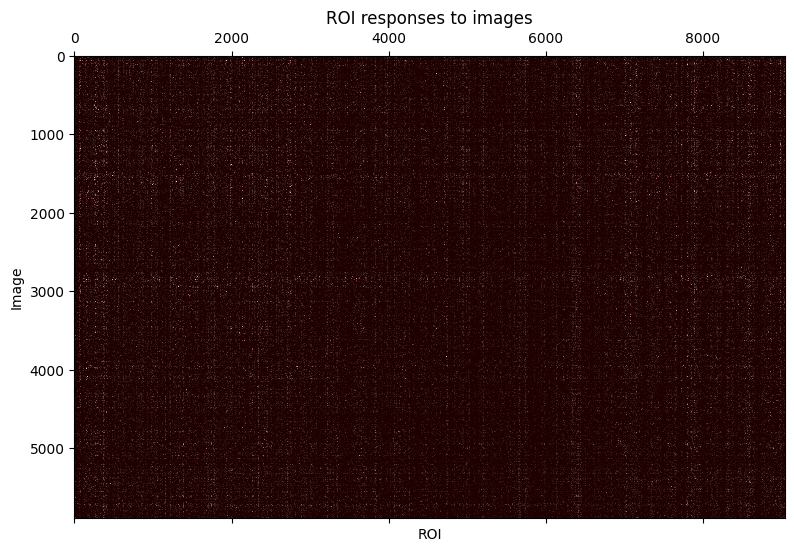

In [60]:
figure(figsize=(14,6))
matshow(X, cmap = cm.pink, fignum=False)
xlabel("ROI")
ylabel("Image")
title("ROI responses to images")

# What is the overall distribution of responses

In [61]:
Xall = X.flatten();
Xall[Xall<=0] = 1e-8

In [62]:
n_bins = int(sqrt(len(Xall)))

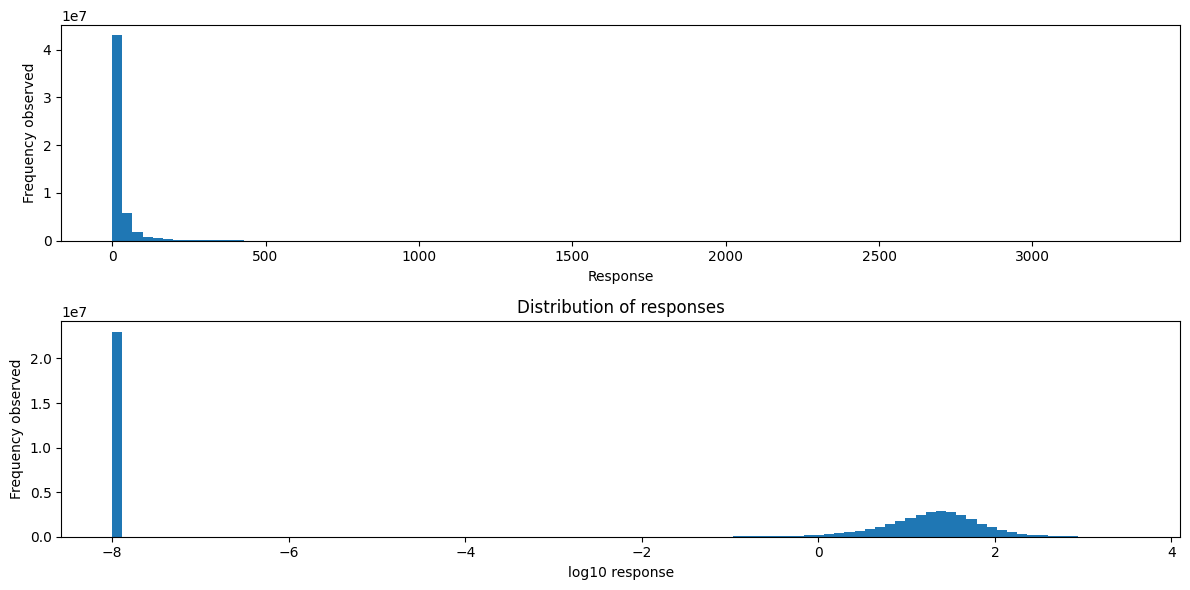

In [63]:
figure(figsize=(12,6))
subplot(2,1,1)
hist(Xall, bins = 100);
xlabel("Response"); ylabel("Frequency observed")
subplot(2,1,2)
hist(log10(Xall), bins = 100);
xlabel("log10 response"); ylabel("Frequency observed")
title("Distribution of responses")
tight_layout()

Dropped 2684 values less than r_min=-2
Dropped 0 values less than r_min=-inf


/var/folders/f4/q6n418p95nb77wmf4l9zydddrkwtmh/T/ipykernel_13409/1481809782.py:1: RuntimeWarning: divide by zero encountered in log10
  r_kept = abib_cdf(log10(X[0]), r_min=-2);


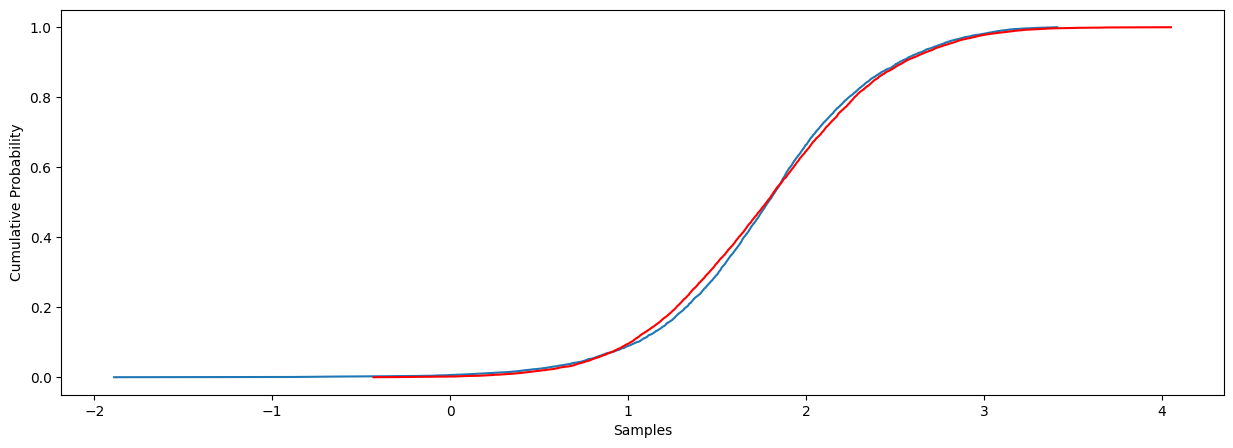

In [64]:
r_kept = abib_cdf(log10(X[0]), r_min=-2);
gauss_data = randn(10000,)* std(r_kept) + mean(r_kept)
abib_cdf(gauss_data, c="r");
xlabel("Samples"); ylabel("Cumulative Probability");

Gaussian data should have skewness of 0. Our data seems to be skewed.

In [65]:
skew(gauss_data), skew(r_kept)

(0.00475312836851896, -0.3648815562804602)

In [72]:
mean(r_kept)

1.7713876

### Exercise for Abib: Fit Gamma distribution, skewed gaussian

Dropped 2684 values less than r_min=-2
Dropped 0 values less than r_min=-inf


/var/folders/f4/q6n418p95nb77wmf4l9zydddrkwtmh/T/ipykernel_74585/335421732.py:6: RuntimeWarning: divide by zero encountered in log10
  r_kept = abib_cdf(log10(X[0]),r_min=-2);


array([1.29371544, 2.27134336, 1.52214879, ..., 3.03286651, 2.24203392,
       1.17267638])

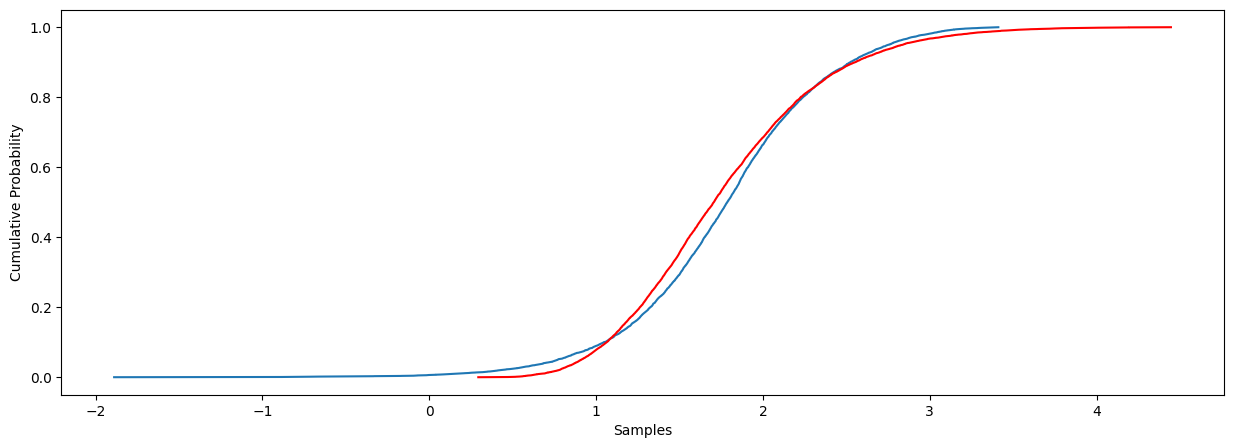

In [55]:
scale_param = std(r_kept)**2 / mean(r_kept)
shape_param = mean(r_kept)/ scale_param

gamma_data = random.gamma(shape_param, scale_param, 10000)

r_kept = abib_cdf(log10(X[0]),r_min=-2);
abib_cdf(gamma_data, c='r')

In [77]:
skew_data = [skewnorm.rvs(j, size=10000) for j in linspace(1, 10)]

In [101]:
linspace(-1, 0, 20)

array([-1.        , -0.94736842, -0.89473684, -0.84210526, -0.78947368,
       -0.73684211, -0.68421053, -0.63157895, -0.57894737, -0.52631579,
       -0.47368421, -0.42105263, -0.36842105, -0.31578947, -0.26315789,
       -0.21052632, -0.15789474, -0.10526316, -0.05263158,  0.        ])

In [109]:
skew_data_loc = []
skew_special = []
for j in linspace(-1, 0, 20):
    target = round(j, 4)
    for l in linspace(0, 2, 10):
        if  target == -0.3684: 
            iid = skewnorm.rvs(j, loc=l, size=1000)
            skew_special.append(iid)
        else:
            skew_data_loc.append(iid)

In [90]:
skew_spec = skewnorm.rvs(a = -0.364, loc= 1.771, size=1000)

In [160]:
mean(log10(r_kept)[~ isnan(log10(r_kept))])

/var/folders/f4/q6n418p95nb77wmf4l9zydddrkwtmh/T/ipykernel_13409/2873371528.py:1: RuntimeWarning: invalid value encountered in log10
  mean(log10(r_kept)[~ isnan(log10(r_kept))])


0.221906

In [ ]:
skew(log10(r_kept)[~ isnan(log10(r_kept))])

In [126]:
log_skew = [skewnorm.rvs(a=k, loc=0.221906, size=1000) for k in linspace(-3, -1, 10) ]

In [161]:
a =skew(log10(spont[:, 0][spont[:, 0] > 0])[~ isnan(log10(spont[:, 0][spont[:, 0] > 0]))])
b =mean(log10(spont[:, 0][spont[:, 0] > 0])[~isnan(log10(spont[:, 0][spont[:, 0] > 0]))])

skew_spont = skewnorm.rvs(a=a, loc=b, size=1000)

# Cross correlations

In [194]:
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

In [ ]:
import time

In [ ]:
start = time.time()
scipy.signal.correlate2d(spont, resp)
print(f'process took {time.time() - start}')

In [11]:
stat0 = time.time()
tt = scipy.signal.fftconvolve(spont, resp)
print(f'process took {time.time() - stat0}')

process took 2.6313281059265137


In [140]:
?scipy.signal.fftconvolve

Text(0.5, 1.0, 'Cross Correlation of Spont vs Resp')

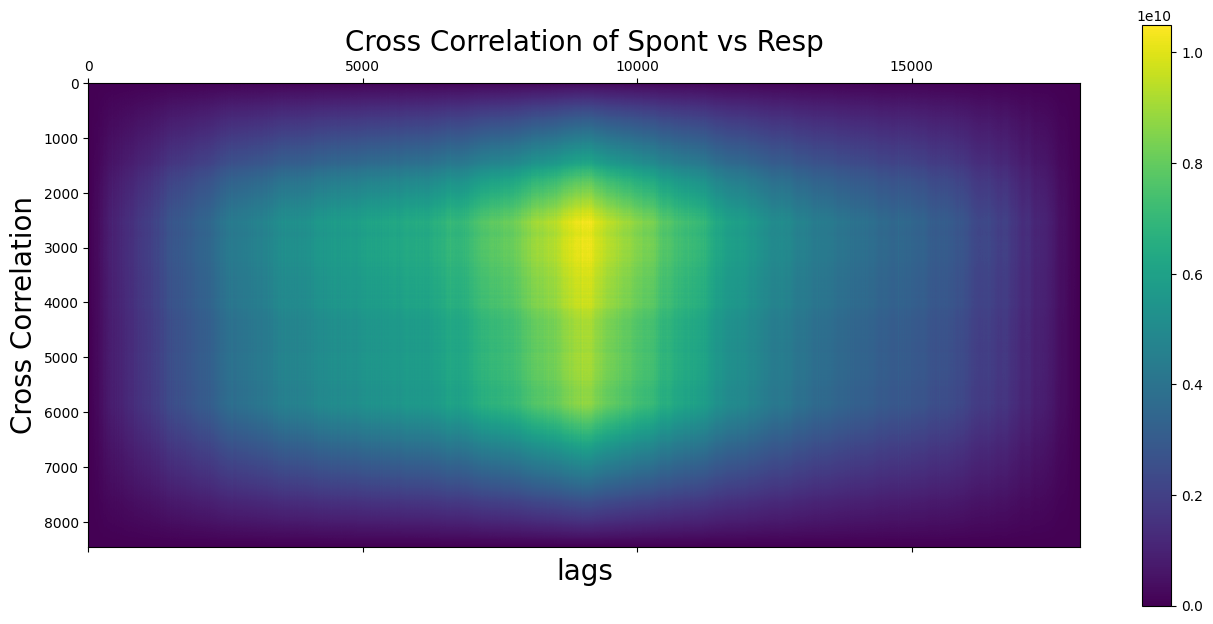

In [144]:
matshow(tt)
colorbar();
xlabel('lags', fontsize=20)
ylabel('Cross Correlation', fontsize=20)
title('Cross Correlation of Spont vs Resp', fontsize=20)

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([0.20114784, 0.17403494, 0.1829178 , 0.17987941, 0.19642891,
        0.18723132, 0.18095762, 0.20948212, 0.19658512, 0.19033535,
        0.42845333, 0.181312  , 0.17199343, 0.19553523, 0.19727065,
        0.17331289, 0.19768387, 0.20547093, 0.18690372, 0.2042305 ,
        0.1834086 ], dtype=float32),
 None)

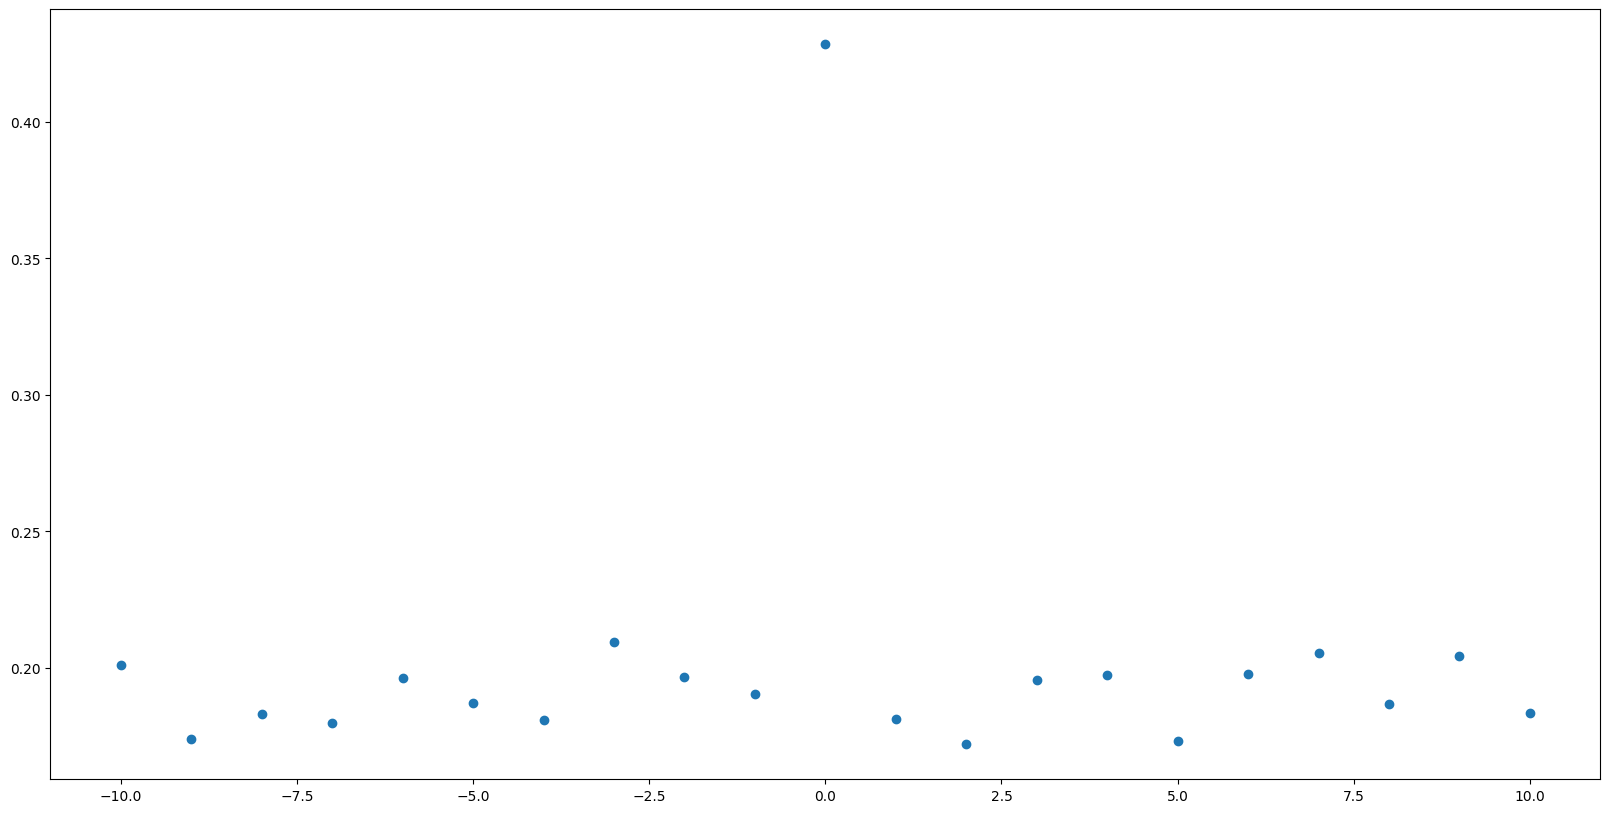

In [139]:
xcorr(spont[0, :], resp[0, :], usevlines=False)

In [135]:
flat_spont = spont.flatten()
flat_resp = resp.flatten()

In [145]:
# compute cross correlations with loop
#xcorr


In [19]:
?scipy.signal.correlate2d

In [221]:
np.convolve([1, 2], [0, 1, 0.5])

array([0. , 1. , 2.5, 1. ])

In [ ]:
def pad_array(v, desired_length, pad_with = np.nan):
    v_new = np.zeros((desired_length,))
    v_new[:len(v)] = v
    v_new[len(v):] = pad_with
    return v_new

In [169]:
spont.shape, resp.shape

((2586, 9039), (5880, 9039))

In [170]:
pad_spont = pad_vector(spont, )

3294

# Plot distribution of responses / neuron

In [73]:
linspace(0, 2, 10)

array([0.        , 0.22222222, 0.44444444, 0.66666667, 0.88888889,
       1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ])

In [84]:
from matplotlib.gridspec import GridSpec

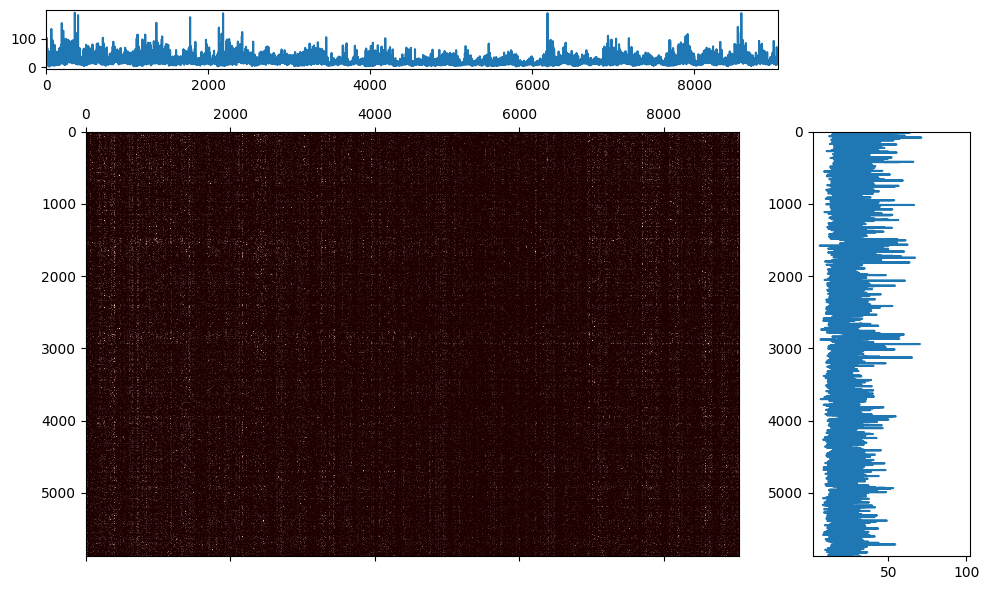

In [91]:
fig=figure(figsize=(10,6))
gs = fig.add_gridspec(5,5)
ax_data = fig.add_subplot(gs[1:,:-1])
matshow(X, cmap=cm.pink, fignum=False)
ax_roi  = fig.add_subplot(gs[0, :-1], sharex=ax_data)
ax_roi.plot(mean(X,axis=0))
ax_stim = fig.add_subplot(gs[1:,-1], sharey=ax_data)
xvals = mean(X,axis=1);
yvals = arange(X.shape[0]);
ax_stim.plot(xvals, yvals)
tight_layout();

# Is there a relation between responses and location

We notice that some neurons respond more to images than others. Why?
Is this due to location?

In [92]:
# locations
x, y, z = data["med"].T
r = np.mean(X,axis=0)

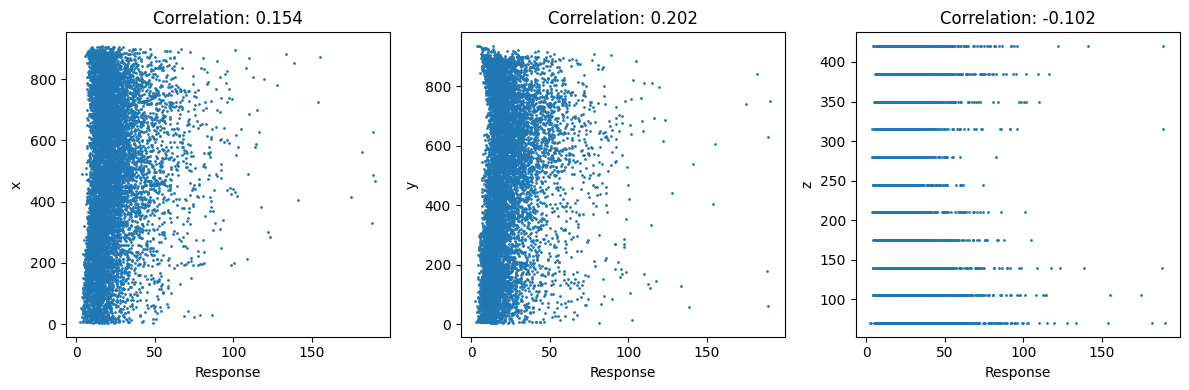

In [93]:
figure(figsize=(12,4))
for i, (name,v) in enumerate(zip("xyz",[x,y,z])):
    subplot(1,3,i+1)
    scatter(r, v, s=1)
    c = corrcoef(r,v)[0,1]
    ylabel(name); xlabel("Response")
    title(f"Correlation: {c:1.3f}")
tight_layout()

# Let's regress responses on X,Y position

In [94]:
from sklearn.linear_model import LinearRegression

In [95]:
lr = LinearRegression()
Xin = np.array([x,y,z]).T
r_pred = lr.fit(Xin, r).predict(Xin)

Text(0.5, 1.0, 'Correlation: 0.281')

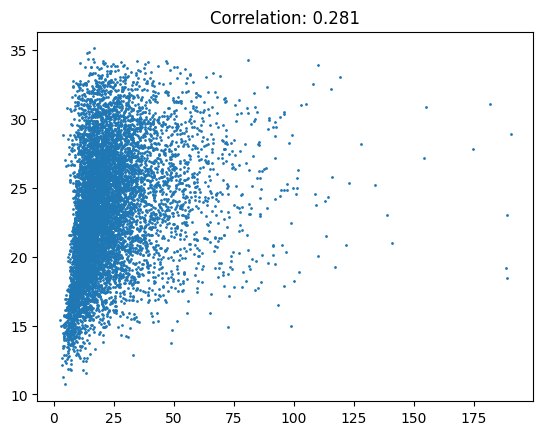

In [96]:
scatter(r, r_pred, s=1);
c = corrcoef(r, r_pred)[0,1]
title(f"Correlation: {c:1.3f}")

# What do the individual neural responses look like?

Text(0, 0.5, 'Images')

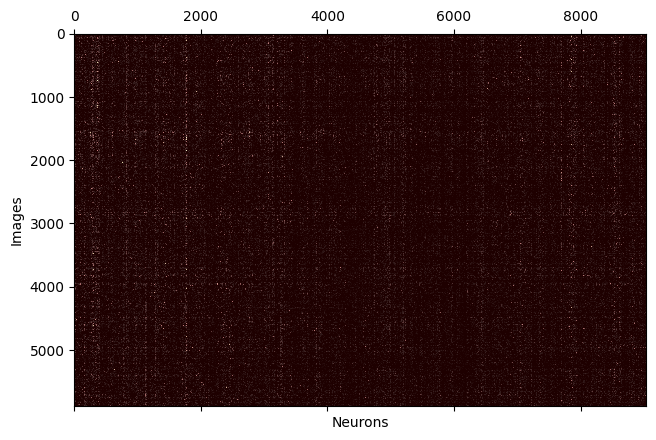

In [97]:
matshow(X, cmap=cm.pink); xlabel("Neurons"); ylabel("Images")

# Abib's question: what do the responses of the most active neuron look like.

In [98]:
n_images, n_neurons = X.shape

In [99]:
r = mean(X, axis=0)

In [100]:
assert len(r) == n_neurons, f"Expected {n_neurons} values, got {len(r)}."

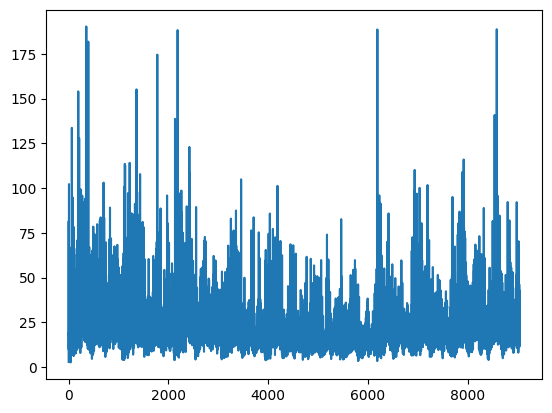

In [102]:
plot(r);

In [103]:
imax = argmax(r)

In [104]:
Xmax = X[:, imax]

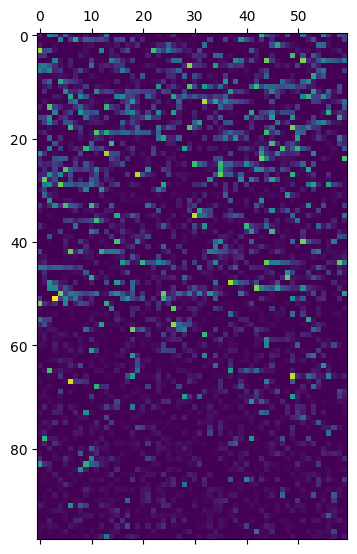

In [117]:
matshow(pad_vector(Xmax, 5880).reshape(98,60));

# Normalize the data

In [108]:
Xstd = std(X,axis=0)
Xvar = var(X,axis=0)

In [109]:
Xm = mean(X,axis=0)

Text(0, 0.5, 'Variance of neuron response')

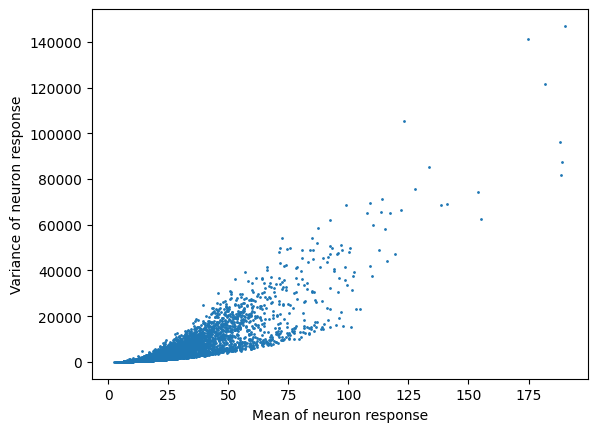

In [110]:
scatter(Xm, Xvar,s=1)
xlabel("Mean of neuron response")
ylabel("Variance of neuron response")

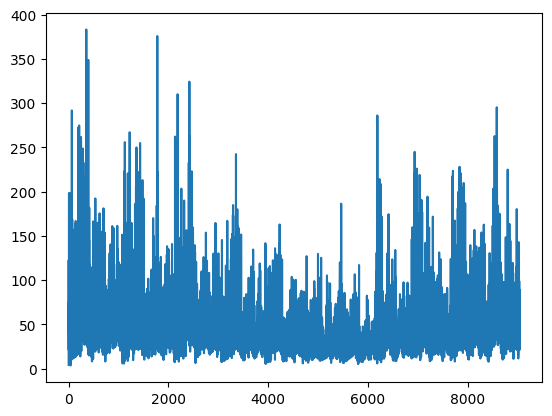

In [112]:
plot(Xstd);

In [113]:
X.shape

(5880, 9039)

In [114]:
Z = X / (Xstd + 1e-12)

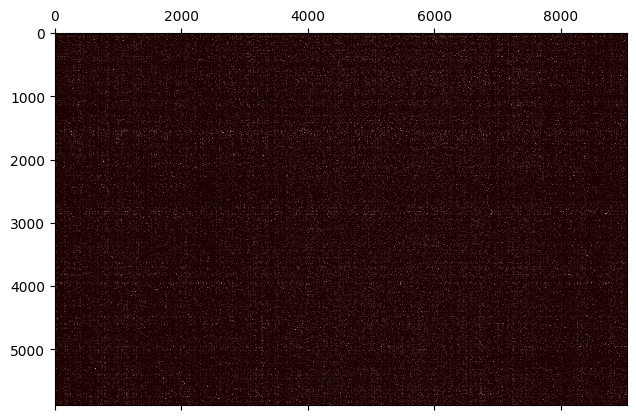

In [116]:
matshow(Z, cmap=cm.pink);

In [183]:
im_order = argsort(Z[:,imax])

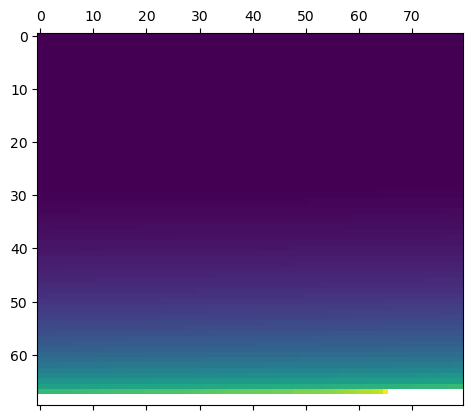

In [188]:
matshow(pad_vector(Z[im_order,imax], 5600).reshape(70,80))

In [41]:
from lmfit.models import SkewedGaussianModel 

In [42]:
?SkewedGaussianModel.fit

In [64]:
r_kept.shape

(6355,)

In [69]:
rcParams['figure.figsize'] = (20, 10)

In [121]:
yy = randn(10000, 10000)
hist2d(yy[0], yy[1], bins=100)
rend_cov(tp)

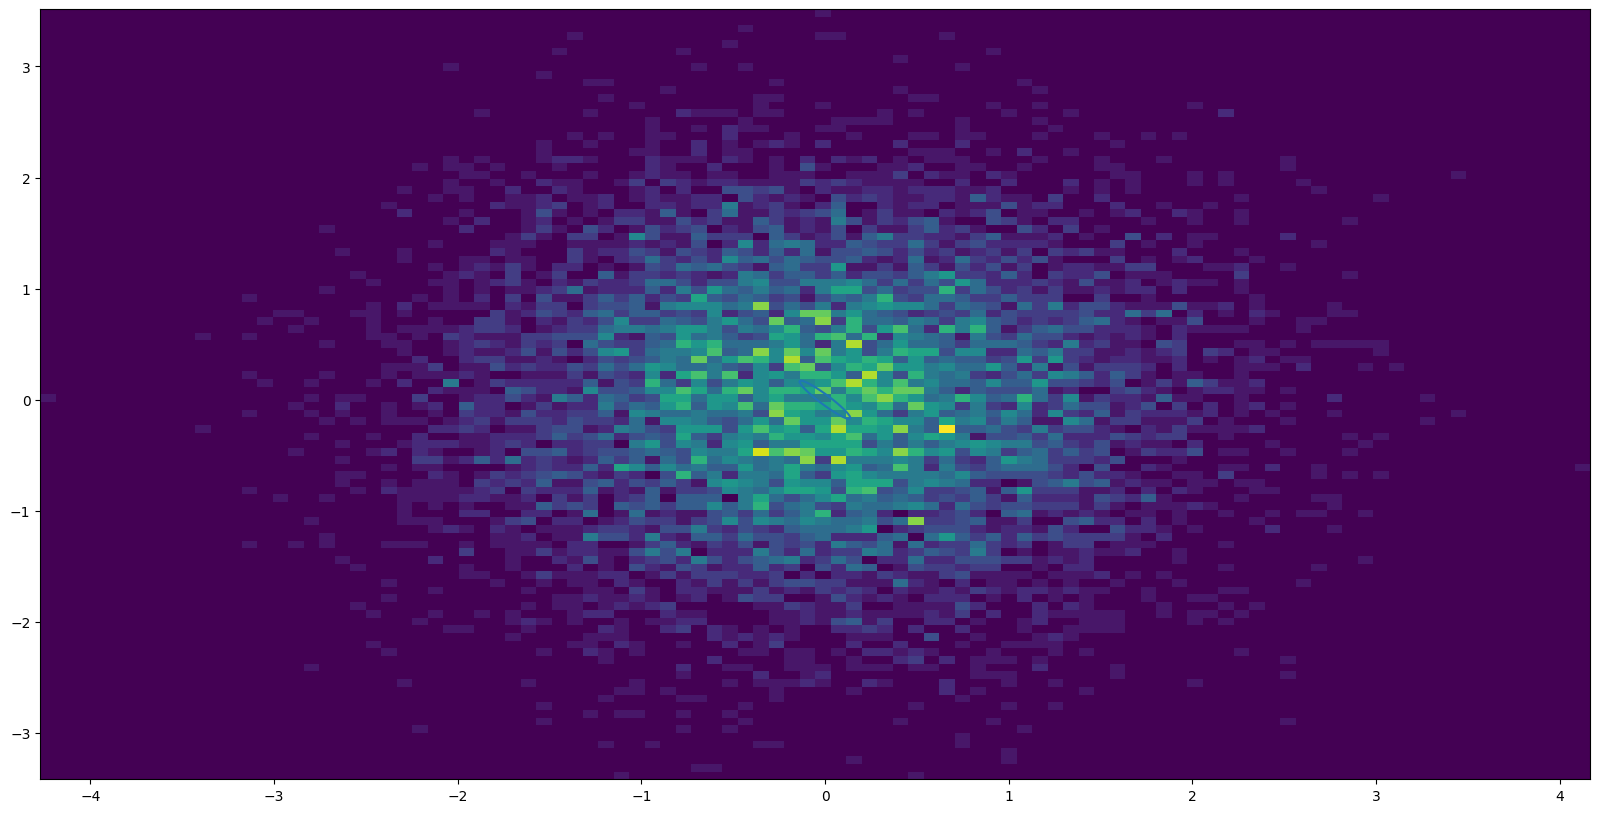

In [125]:
hist2d(yy[0], yy[1], bins=100)
rend_cov(tp)

In [77]:
scipy.linalg.svdvals(yy)

array([415.88755882, 415.69150526, 415.57235128, ..., 216.69740844,
       216.61386742, 216.29245393])

In [118]:
def rend_cov(x):
    xe, xv = eigsh(x, k=2)
    xe_ = np.sqrt(abs(sort(xe)))
    xe_ = xe_[:2, ]
    t = linspace(0, 2*pi, 100)
    t_ = np.array([cos(t), sin(t)])
    es = xv @ (xe_.reshape(2, 1) * t_) 
    plot(es[0], es[1], )
    

    return None

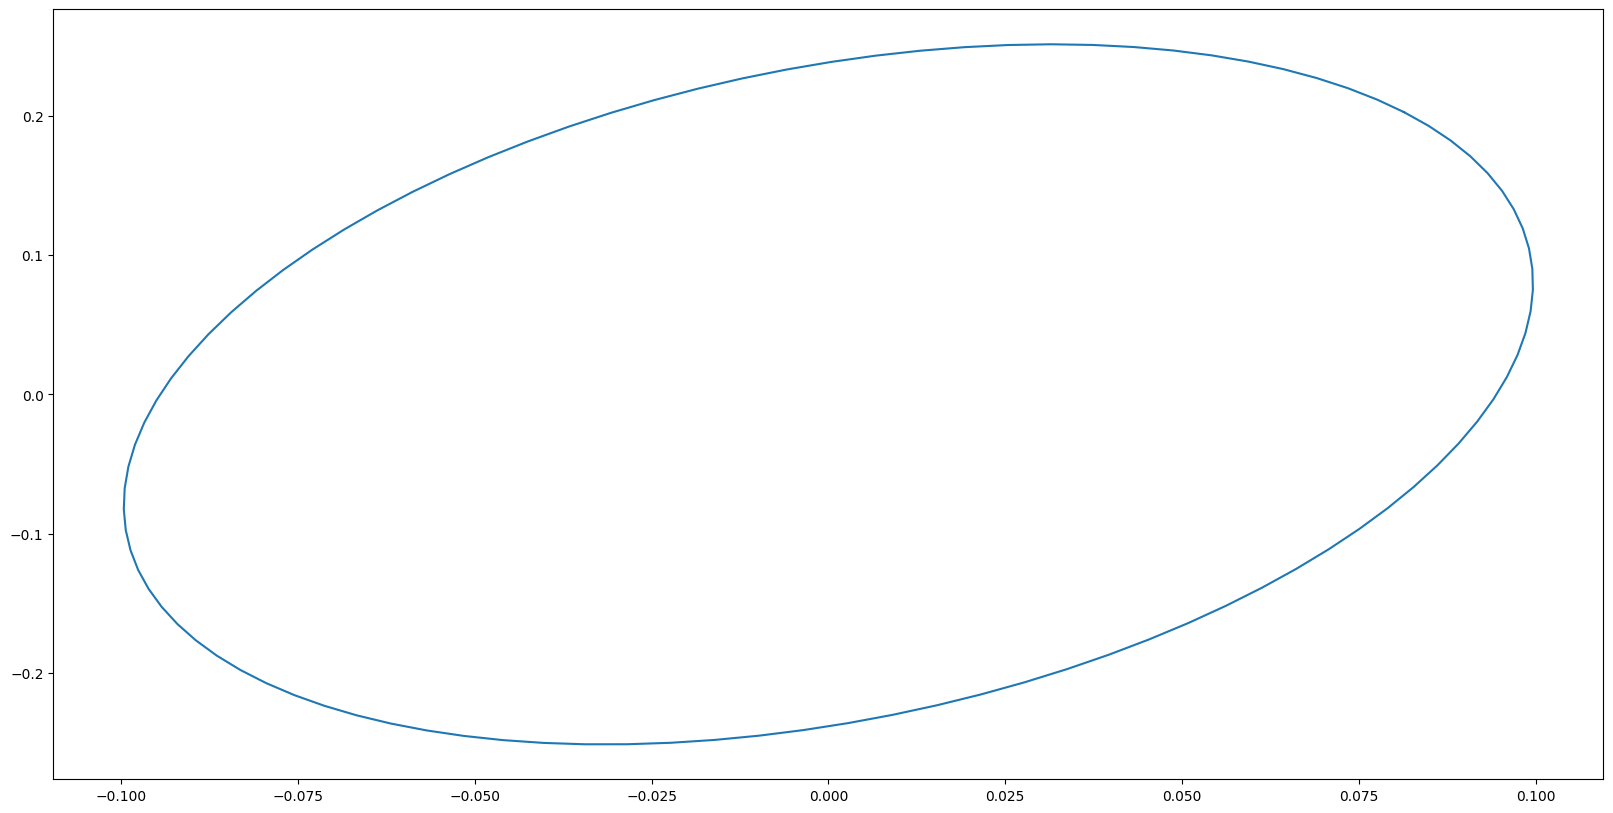

In [123]:
rend_cov(yy)

In [86]:
vf,  ve = eigsh(yy)

In [95]:
vf_ = np.sqrt(sort(vf))

/var/folders/f4/q6n418p95nb77wmf4l9zydddrkwtmh/T/ipykernel_35652/3192238658.py:1: RuntimeWarning: invalid value encountered in sqrt
  vf_ = np.sqrt(sort(vf))


In [96]:
vf_  = sort(vf_)[:2, ]

In [97]:
vf_

array([14.03478349, 14.03834609])

In [104]:
ss = sort(vf)[:2, ]

In [110]:
ve.shape

(10000, 6)

In [103]:
??sort

In [111]:
yyy = yy @ yy.T

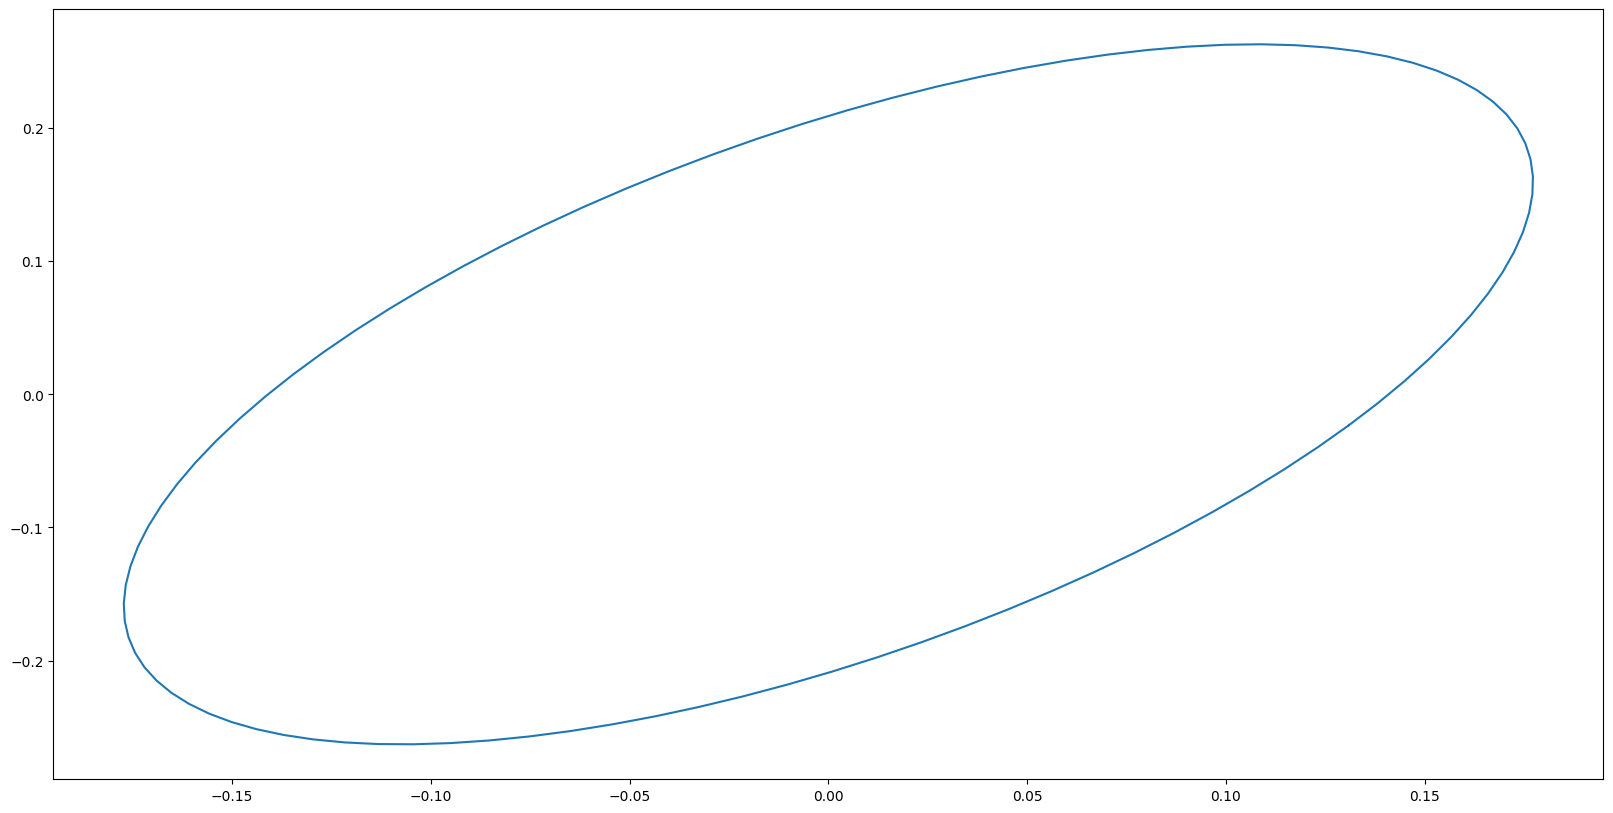

In [117]:
rend_cov(yy)

In [124]:
tp = yy * yy.T

In [148]:
x = arange(18078)

In [150]:
values = x - 9039

In [151]:
?xcorr

In [1]:
?scipy.signal.fftconvolve()

Object `scipy.signal.fftconvolve()` not found.


In [5]:
?fftconvolve()

Object `fftconvolve()` not found.
